## 1. Imports

**FinanceDataReader 패키지를 활용해 SP500의 주식 데이터를 수집**  
SP500의 구성종목 중 2013-01-01~ 2023-01-31에 결측치가 존재하지 않는 주식에 대해 데이터를 수집  
이후의 결과 비교를 위해 SP500지수를 benchmark로 설정

In [1]:
import FinanceDataReader as fdr
import pickle

import mybacktest as backtest # 자체 제작한 모듈

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from datetime import datetime
from time import time
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
start_date = "2013-01-01"
end_date = "2023-01-31"

In [3]:
benchmark = fdr.DataReader("US500", "2013-01-01", "2023-01-31")
benchmark = benchmark['Adj Close']
benchmark

Date
2013-01-02    1462.420044
2013-01-03    1459.369995
2013-01-04    1466.469971
2013-01-07    1461.890015
2013-01-08    1457.150024
                 ...     
2023-01-24    4016.949951
2023-01-25    4016.219971
2023-01-26    4060.429932
2023-01-27    4070.560059
2023-01-30    4017.770020
Name: Adj Close, Length: 2537, dtype: float64

In [4]:
sp500 = pd.read_csv('data/sp500.csv', index_col=0)
sp500.index = pd.to_datetime(sp500.index, format = "%Y-%m-%d")
sp500.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,68.910484,13.831623,26.270302,22.895281,57.066193,10.133719,21.668747,38.340000,40.810844,66.654129,...,18.928724,75.177574,172.004929,96.061661,19.723278,23.984154,39.681404,40.959999,60.438889,18.007874
2013-01-03,68.830513,13.615402,27.270285,22.706224,56.859608,10.189247,21.494911,37.750000,40.971615,66.654129,...,18.784111,75.945602,171.458481,97.094917,19.665646,23.905657,39.929573,41.000000,61.304848,18.032446
2013-01-04,69.339470,13.763116,27.106354,22.419382,57.173618,10.337319,22.084427,38.130001,41.335064,67.693153,...,18.989914,75.923622,172.576324,98.266502,19.737686,23.870773,40.366798,40.669998,61.617310,18.548359
2013-01-07,69.426735,13.611119,27.327662,22.465015,56.925716,10.346575,21.169909,37.939999,41.174297,67.463303,...,18.906479,75.704216,171.499863,98.600075,19.528786,23.556799,40.112728,40.900002,61.769085,18.458282
2013-01-08,69.433960,13.870156,27.335859,21.976084,57.256248,10.170738,21.419329,38.139999,41.411934,66.359901,...,18.672855,75.331192,168.634964,98.518715,19.564804,23.268984,38.428806,40.930000,61.858360,18.089766


In [5]:
tickers = sp500.columns.tolist()

## 2. 전략 수립 및 검증

### 2-1 개요

##### **모멘텀은 최근의 수익률을 의미(Ex) 최근 20일 수익률, 60일 수익률, 100일 수익률)**  
모멘텀의 값이 높은 주식을 매수, 낮은 주식을 매수하는 방식으로 포트폴리오를 설계,그 결과를 검증   
우선, 2013-06-01~ 2020-06-01까지의 기간을 대상으로 전략을 수립, 그 결과를 검증  
(팩터를 산출하기 위해서 과거의 데이터까지 가져옴)
###### **만약, 결과가 안 좋을 시 다른 방식으로 전략을 수정**  

**cf) 백테스트 방식**  
각 날짜별로 보유 비중을 정하고, 해당 기간동안 각 자산을 전체자산 대비 정해진 비중만큼 매수 또는 매도.  
즉, 각 자산을(전체자산(현금+보유주식)* 비중) 매수 또는 매도(소수점 이하 버림).이 때, 현금에 대해서는  
매일 이자가 붙고, 매수/매도 시에는 수수료(commission)을, 매도시에는 세금(tax)를 추가로 납부.  
자세한 내용은 mybacktest 코드 참조  

In [6]:
start, end = "2013-01-01", "2020-06-01"

In [7]:
price_df = sp500[(sp500.index >= start) & (sp500.index <= end)]
price_df.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,68.910484,13.831623,26.270302,22.895281,57.066193,10.133719,21.668747,38.340000,40.810844,66.654129,...,18.928724,75.177574,172.004929,96.061661,19.723278,23.984154,39.681404,40.959999,60.438889,18.007874
2013-01-03,68.830513,13.615402,27.270285,22.706224,56.859608,10.189247,21.494911,37.750000,40.971615,66.654129,...,18.784111,75.945602,171.458481,97.094917,19.665646,23.905657,39.929573,41.000000,61.304848,18.032446
2013-01-04,69.339470,13.763116,27.106354,22.419382,57.173618,10.337319,22.084427,38.130001,41.335064,67.693153,...,18.989914,75.923622,172.576324,98.266502,19.737686,23.870773,40.366798,40.669998,61.617310,18.548359
2013-01-07,69.426735,13.611119,27.327662,22.465015,56.925716,10.346575,21.169909,37.939999,41.174297,67.463303,...,18.906479,75.704216,171.499863,98.600075,19.528786,23.556799,40.112728,40.900002,61.769085,18.458282
2013-01-08,69.433960,13.870156,27.335859,21.976084,57.256248,10.170738,21.419329,38.139999,41.411934,66.359901,...,18.672855,75.331192,168.634964,98.518715,19.564804,23.268984,38.428806,40.930000,61.858360,18.089766


### 2-2 전략 수립 및 검증(1) - 20일 모멘텀(Long-Short)

##### **20일 모멘텀의 값이 0보다 큰 것 중 상위 100개 매수, 0보다 작은 것 중 하위 100개 매도**  
이 때, 만약 매수 또는 매도하는 것의 개수가 20개 미만이면 매수 매도를 하지 않음  
투자금액은 1,000,000달러로 설정  
각 매수/매도하는 자산의 비중은 1/100로 정함  
거래비용은 수수료 0.015% (매수, 매도 시 모두 부여), 증권거래세 0.2% (매도 시에만 부여)  
이자율은 연 3%를 1일 단위로 바꾼 것으로 설정($(1+0.03)^{(1/252)}-1 $)  
리밸런싱 주기는 20영업일로 설정(20영업일 마다 비중 재조정)

##### **해당 기간의 누적수익률은 -45.76%로 좋지 않은 수익률을 보임(연간 -8.38%)**   
##### **해당기간의 벤치마크(SP500) 누적수익률은 87.38%(연간 9.40%)**    
test_factor를 활용해 각 분위별 Long Only Portfolio의 성과를 비교해 본 결과,  
1분위 Long-Only Portfolio가 가장 좋은 수익률을 보였고, 분위가 높아질수록 수익률이 떨어짐  
(Ex) 20일 모멘텀 1분위인 종목들에 대해 동일가중 방식으로 매수, 리밸런싱 주기는 20일)  
다만 MDD 및 변동성은 1분위에서 가장 나쁘게 나타남   

In [8]:
commission = 0.00015
tax = 0.002
interest = (1+0.03) ** (1/252) - 1
money = 1e6
start = "2013-06-01"

In [9]:
factor_df = price_df.pct_change(20).dropna()
factor_df = factor_df[(factor_df.index >= start) & (factor_df.index <= end)]
factor_df.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WMB,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2013-06-03,0.031629,0.020387,0.009783,-0.029543,0.032704,-0.036232,-0.039955,-0.075516,0.004622,-0.023770,...,-0.068993,-0.040392,0.043371,0.002184,-0.074383,0.036686,0.001451,-0.008900,0.023767,0.100197
2013-06-04,0.026032,-0.009711,0.026500,-0.021529,0.030830,-0.032930,-0.020499,-0.045171,0.004222,-0.034389,...,-0.076140,-0.038471,0.036812,-0.006101,-0.059322,0.020509,0.007020,-0.013675,0.008317,0.058360
2013-06-05,0.011102,-0.014081,0.006655,-0.041639,0.006705,-0.042838,-0.045333,-0.038596,-0.011508,-0.047090,...,-0.067271,-0.034211,-0.002291,-0.036445,-0.086301,-0.013385,-0.008598,-0.030641,-0.001682,0.024592
2013-06-06,0.010070,-0.001940,0.009644,0.000230,-0.005625,-0.041940,-0.045537,-0.038614,-0.009043,-0.022204,...,-0.010965,-0.036168,0.006359,-0.028090,-0.062885,-0.024906,0.022133,-0.024353,0.001407,0.037666
2013-06-07,0.016589,-0.000258,0.036761,-0.005425,0.010114,0.023627,-0.024034,0.003411,-0.015571,-0.004721,...,-0.034358,-0.020982,0.035852,-0.014690,-0.035726,-0.007858,0.064427,-0.026749,0.005749,0.053809


In [10]:
rebalance_period=20
rebalance_dates = factor_df.index[::rebalance_period].tolist()

In [11]:
signal = backtest.generate_signal_using_factor(factor_df, n_positions=100,
                                               long_min=0, short_max=0, long_short=True)

In [12]:
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=100,
                                                              n_min_positions=20, long_short=True)

In [13]:
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [14]:
cumulative_return = backtest.calculate_cumulative_return(daily_return)
cumulative_return

2013-06-03   -0.002177
2013-06-04   -0.001158
2013-06-05   -0.006667
2013-06-06   -0.009225
2013-06-07   -0.001243
                ...   
2020-05-26   -0.449742
2020-05-27   -0.449678
2020-05-28   -0.449613
2020-05-29   -0.450804
2020-06-01   -0.457649
Length: 1762, dtype: float64

In [15]:
benchmark_return = benchmark.pct_change().dropna()
benchmark_return = benchmark_return[(benchmark_return.index >= daily_return.index[0]) & 
                            (benchmark_return.index <= daily_return.index[-1])]

In [16]:
benchmark_cumulative_return = backtest.calculate_cumulative_return(benchmark_return)
benchmark_cumulative_return

Date
2013-06-03    0.005936
2013-06-04    0.000392
2013-06-05   -0.013393
2013-06-06   -0.005016
2013-06-07    0.007751
                ...   
2020-05-26    0.834609
2020-05-27    0.861811
2020-05-28    0.857887
2020-05-29    0.866827
2020-06-01    0.873830
Name: Adj Close, Length: 1762, dtype: float64

In [17]:
summary_stats = backtest.summary_stats(daily_return,rf=0, alpha=0.05, min_return=0, year=252, benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,-45.76%,87.38%
Annualized Return,-8.38%,9.40%
Annualized Std,11.41%,17.23%
Annualized Sharpe,-70.99%,60.80%
MDD,-57.60%,-33.92%
Var,-27.14%,-18.94%
C_Var,-31.91%,-26.14%
Shortfall Prob(min_return=0.00%),76.87%,29.27%


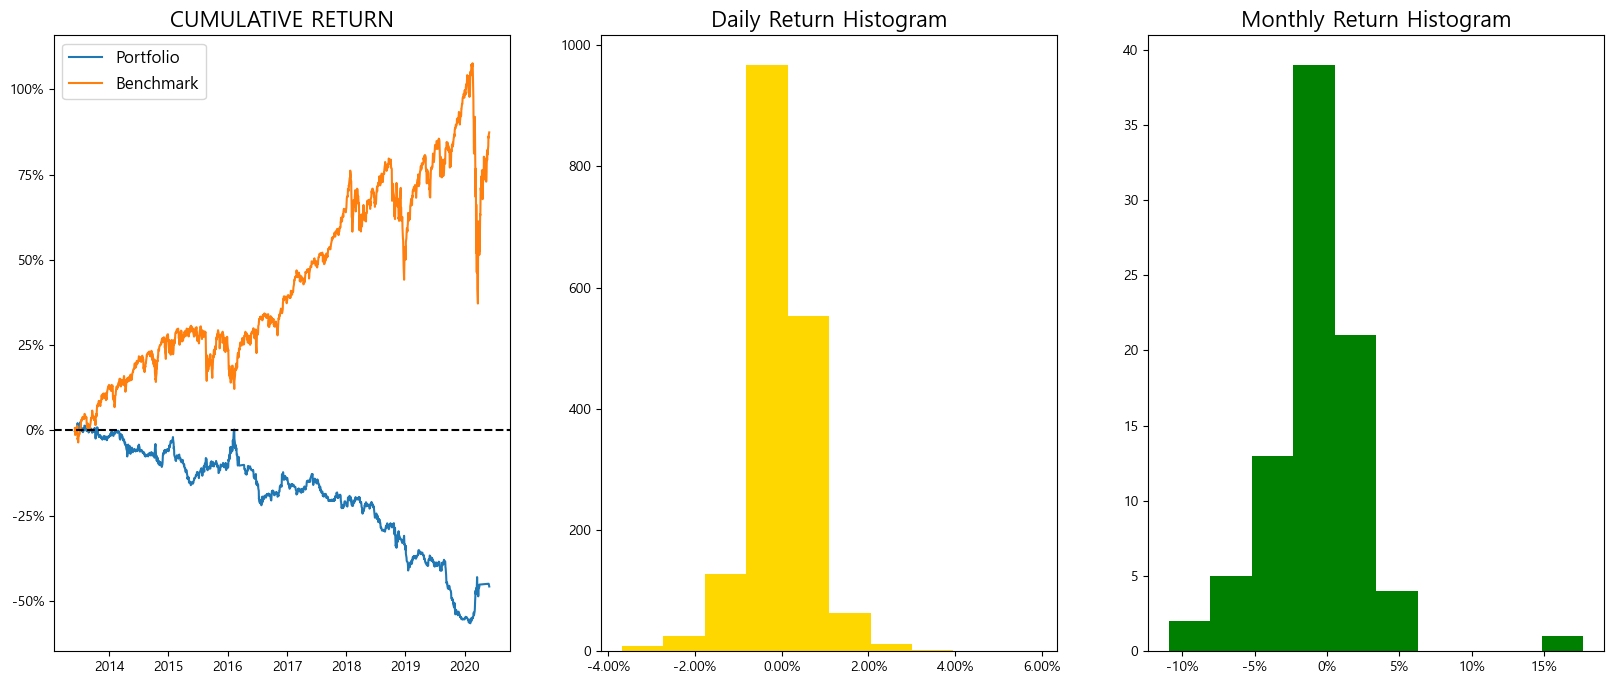

In [18]:
backtest.plot_return(daily_return, benchmark_return)

In [19]:
factor_test = backtest.test_factor(5, price_df, factor_df, money, rebalance_dates, 
                                   commission, interest, tax)
factor_test

,Q1,Q2,Q3,Q4,Q5
Annualized_return,0.198118,0.166157,0.140989,0.124213,0.092835
Annualized_std,0.218397,0.187006,0.174102,0.168414,0.174709
Annualized_sharpe,0.937560,0.916356,0.845247,0.779956,0.595803
MDD,-0.457379,-0.414276,-0.356779,-0.324437,-0.368890


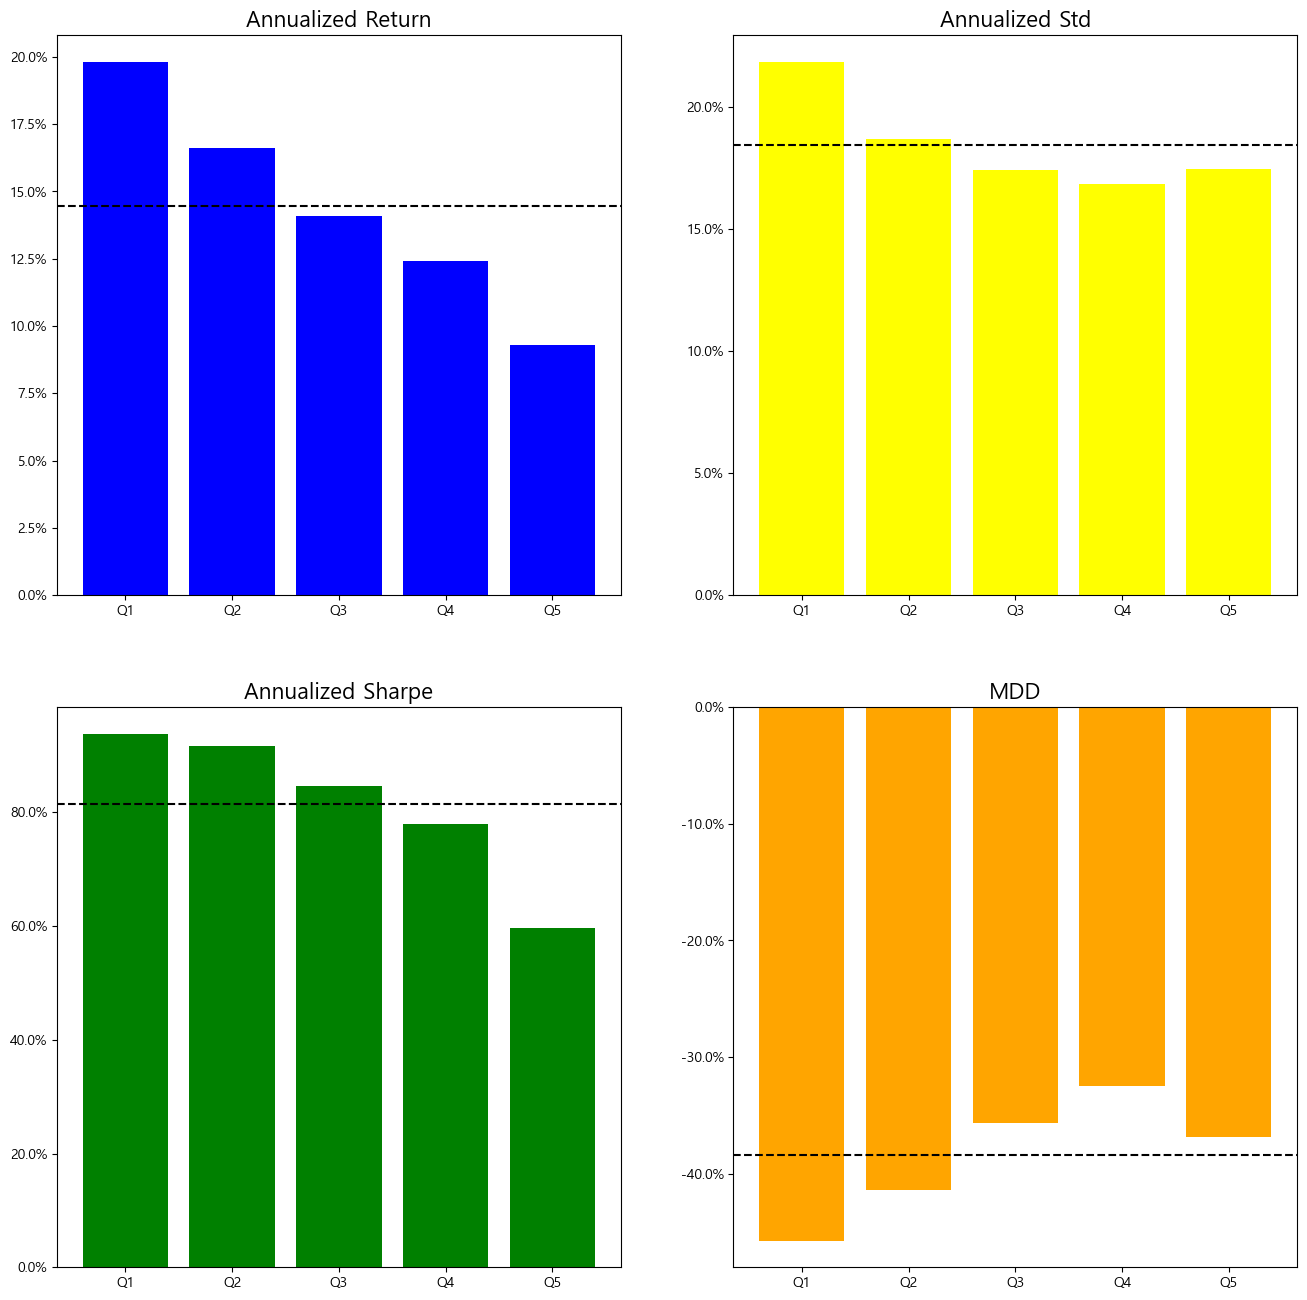

In [20]:
backtest.plot_factor_test_result(5, price_df, factor_df, money, rebalance_dates, commission,
                                interest, tax)

### 2-3 전략 수립 및 검증(2) - 20일 역모멘텀 전략(Long Only)

##### 2-2의 결과를 통해 모든 분위의 포트폴리오가 양의 수익률을 보이고 있는 것을 확인  
##### Long-Short보다는 Long-Only를 하는 것이 더 나은 수익률을 가져올 수도 있을 것으로 분석

##### **5일 모멘텀의 값 하위 100개 매수**    
매수하는 자산의 비중은 1/100로 정함  
투자금액, 세금, 이자율, 수수료 등은 이전과 동일하다고 가정  
20일 모멘텀에 -1을 곱한 것을 팩터로 사용하고, 리밸런싱 주기는 20일로 설정  

##### **해당 기간의 누적수익률은 207.45%로 좋은 수익률을 보임(연간 17.43%)**    
##### **해당기간의 벤치마크(SP500) 누적수익률은 87.38%(연간 9.40%)**    
test_factor를 활용해 각 분위별 Long Only Portfolio의 성과를 비교해 본 결과,  
5분위 Long-Only Portfolio가 가장 좋은 수익률을 보였고, 분위가 높아질수록 수익률이 상승함    

In [21]:
factor_df = price_df.pct_change(20).dropna().mul(-1)
factor_df = factor_df[(factor_df.index >= start) & (factor_df.index <= end)]
rebalance_period=20
rebalance_dates = factor_df.index[::rebalance_period].tolist()
signal = backtest.generate_signal_using_factor(factor_df, n_positions=100,
                                               long_min=-np.inf, short_max=np.inf, long_short=False)
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=100,
                                                              n_min_positions=0, long_short=False)
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [22]:
summary_stats = backtest.summary_stats(daily_return,benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,207.45%,87.38%
Annualized Return,17.43%,9.40%
Annualized Std,21.65%,17.23%
Annualized Sharpe,85.09%,60.80%
MDD,-45.87%,-33.92%
Var,-18.18%,-18.94%
C_Var,-27.23%,-26.14%
Shortfall Prob(min_return=0.00%),21.04%,29.27%


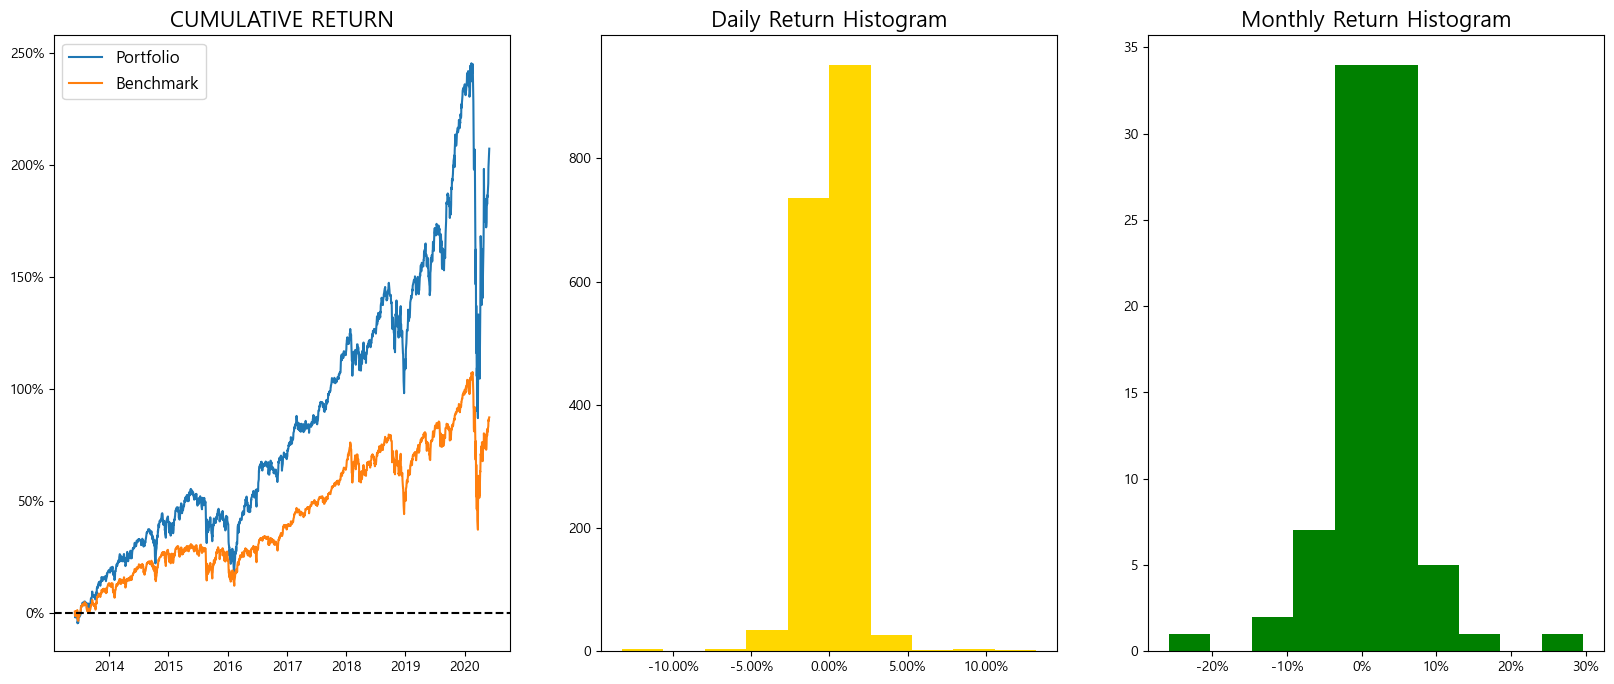

In [23]:
backtest.plot_return(daily_return, benchmark=benchmark_return)

In [24]:
factor_test = backtest.test_factor(5, price_df, factor_df, 1e6,rebalance_dates, 
                                   commission, interest, tax)
factor_test

,Q1,Q2,Q3,Q4,Q5
Annualized_return,0.096910,0.124596,0.139753,0.166690,0.188364
Annualized_std,0.175526,0.168556,0.173698,0.186721,0.216274
Annualized_sharpe,0.615051,0.781468,0.840555,0.919910,0.906861
MDD,-0.357778,-0.324677,-0.351453,-0.413405,-0.456017


## 3. 전략 최적화 및 추가 분석

### 3-1 전략 최적화

##### 2-3의 전략을 수정해서 보다 더 좋은 성과를 내는 전략을 찾고자 함    
20일, 40일, 60일, 80일, 100일 등을 기준으로 모멘텀을 산출하고, 리밸런싱 주기도  20일, 40일,  60일, 80일, 100일 등으로 변경     
샤프비율을 기준으로 순위를 매겨 봄   
전체적인 방식은 2-3과 동일

##### 다양한 전략들을 샤프비율을 기준으로 테스트해본 결과, 
##### 80일 모멘텀, 40일  단위로 리밸런싱이 가장 적합할 것으로 보여짐    

In [26]:
commission = 0.00015
tax = 0.002
interest = (1+0.03) ** (1/252) - 1
money = 1e6
start = "2013-06-01"

factor_periods = [20, 40, 60, 80, 100]
rebalance_periods = [20, 40, 60, 80, 100]
result_df = []
for factor_period in factor_periods:
    for rebalance_period in rebalance_periods:
        factor_df = price_df.pct_change(factor_period).dropna().mul(-1)
        factor_df = factor_df[(factor_df.index >= start) & (factor_df.index <= end)]
        signal = backtest.generate_signal_using_factor(factor_df, n_positions=100,
                                           long_min=-np.inf, short_max=np.inf, long_short=False)
        rebalance_dates = factor_df.index[::rebalance_period].tolist()
        weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=100,
                                                                      n_min_positions=0, long_short=False)
        daily_return = backtest.backtest_from_weights(price_df, weights, money,
                                    rebalance_dates, commission, tax, interest)
        annualized_return = backtest.annualize_return(daily_return)
        annualized_sharpe = backtest.annualize_sharpe(daily_return)
        result_df.append([factor_period, rebalance_period, annualized_return, annualized_sharpe])
opt_df = pd.DataFrame(result_df, columns=['factor_period', 'rebalance_period',
                                          'annualized_return', 'annualized_sharpe'])
opt_df = opt_df.sort_values(by='annualized_sharpe', ascending=False)
opt_df = opt_df.reset_index(drop=True)
opt_df.head(10)

,factor_period,rebalance_period,annualized_return,annualized_sharpe
0,80,40,0.186307,0.915699
1,40,80,0.156978,0.860942
2,20,20,0.174253,0.850932
3,40,60,0.161048,0.850485
4,40,40,0.162631,0.819021
5,100,40,0.163011,0.810103
6,60,80,0.151054,0.808902
7,80,60,0.151120,0.804696
8,80,80,0.144150,0.799150
9,40,100,0.152682,0.795822


##### 80일 모멘텀, 리밸런싱 주기 40일

In [27]:
factor_df = price_df.pct_change(80).dropna().mul(-1)
factor_df = factor_df[(factor_df.index >= start) & (factor_df.index <= end)]
rebalance_period=40
rebalance_dates = factor_df.index[::rebalance_period].tolist()
signal = backtest.generate_signal_using_factor(factor_df, n_positions=100,
                                               long_min=-np.inf, short_max=np.inf, long_short=False)
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=100,
                                                              n_min_positions=0, long_short=False)
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [28]:
summary_stats = backtest.summary_stats(daily_return,rf=0, alpha=0.05, min_return=0, year=252, benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,230.21%,87.38%
Annualized Return,18.63%,9.40%
Annualized Std,21.09%,17.23%
Annualized Sharpe,91.57%,60.80%
MDD,-38.45%,-33.92%
Var,-16.06%,-18.94%
C_Var,-24.87%,-26.14%
Shortfall Prob(min_return=0.00%),18.85%,29.27%


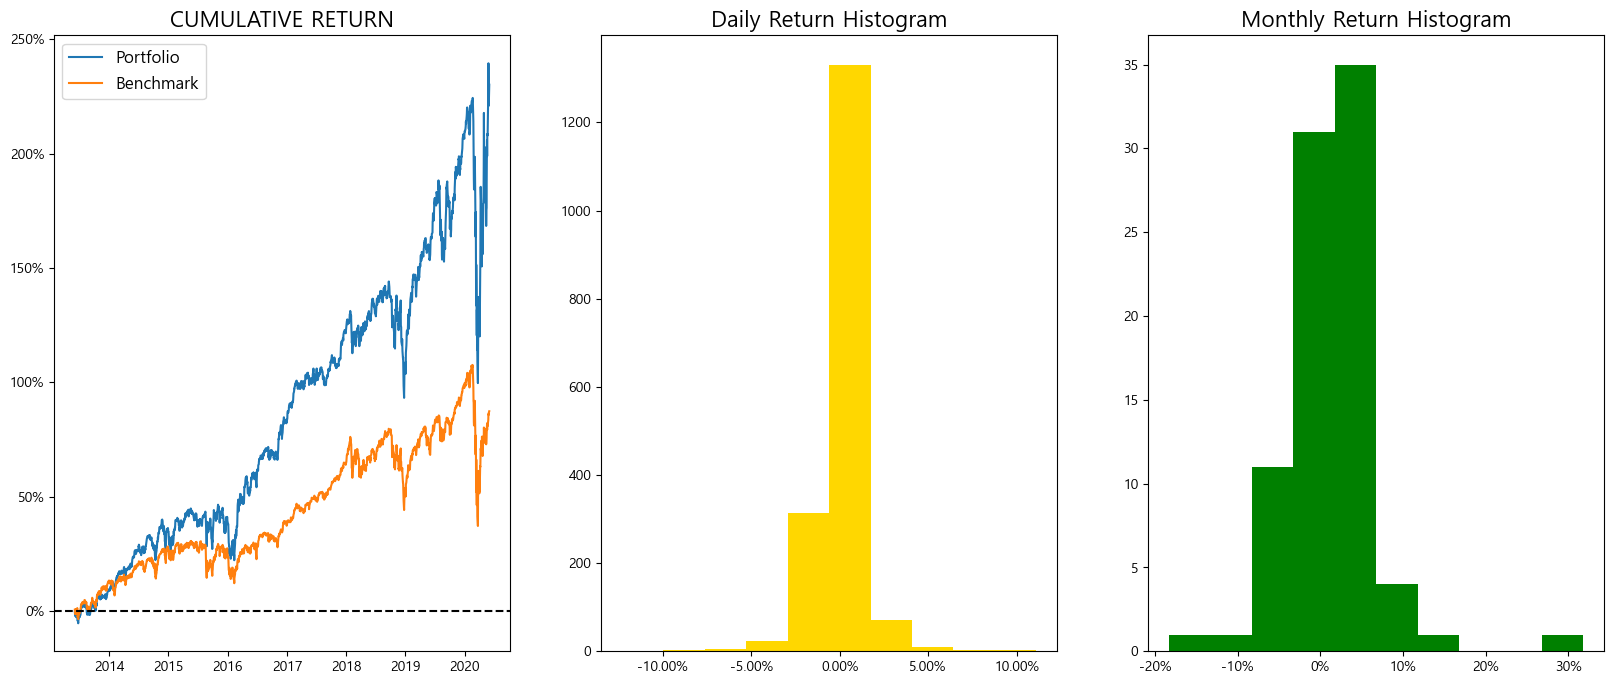

In [29]:
backtest.plot_return(daily_return, benchmark=benchmark_return)

### 3-2 추가분석

#####  Pyfolio, Quantstats 등의 Package를 활용해 보다 추가적인 분석을 진행하기로 함
전체적으로 좋은 성과를 보여주고 있음을 확인할 수 있다  
다만 변동성이 크고, 2020년초와 같이 급락하는 구간이 있다는 점은 우려점

In [30]:
import pyfolio as pf
import quantstats as qs
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe

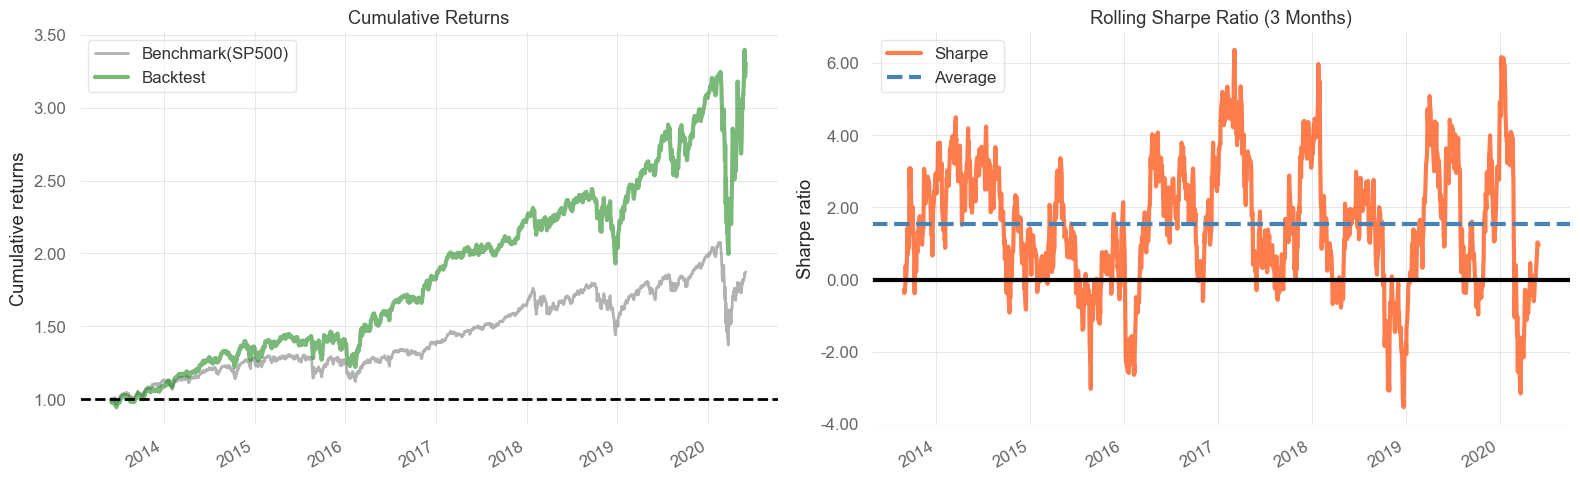

In [31]:
benchmark_return.name='Benchmark(SP500)'
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(daily_return,
                     factor_returns=benchmark_return,
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout()

Start date,2013-06-03
End date,2020-06-01
Total months,83
,Backtest
Annual return,18.631%
Cumulative returns,230.211%
Annual volatility,21.088%
Sharpe ratio,0.92
Calmar ratio,0.48
Stability,0.96
Max drawdown,-38.446%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.45,2020-02-20,2020-03-23,2020-05-26,69
1,20.85,2018-09-21,2018-12-24,2019-02-15,106
2,16.56,2015-11-03,2016-02-11,2016-03-04,89
3,12.32,2019-07-24,2019-08-27,2019-11-04,74
4,12.24,2015-05-19,2015-09-28,2015-11-02,120


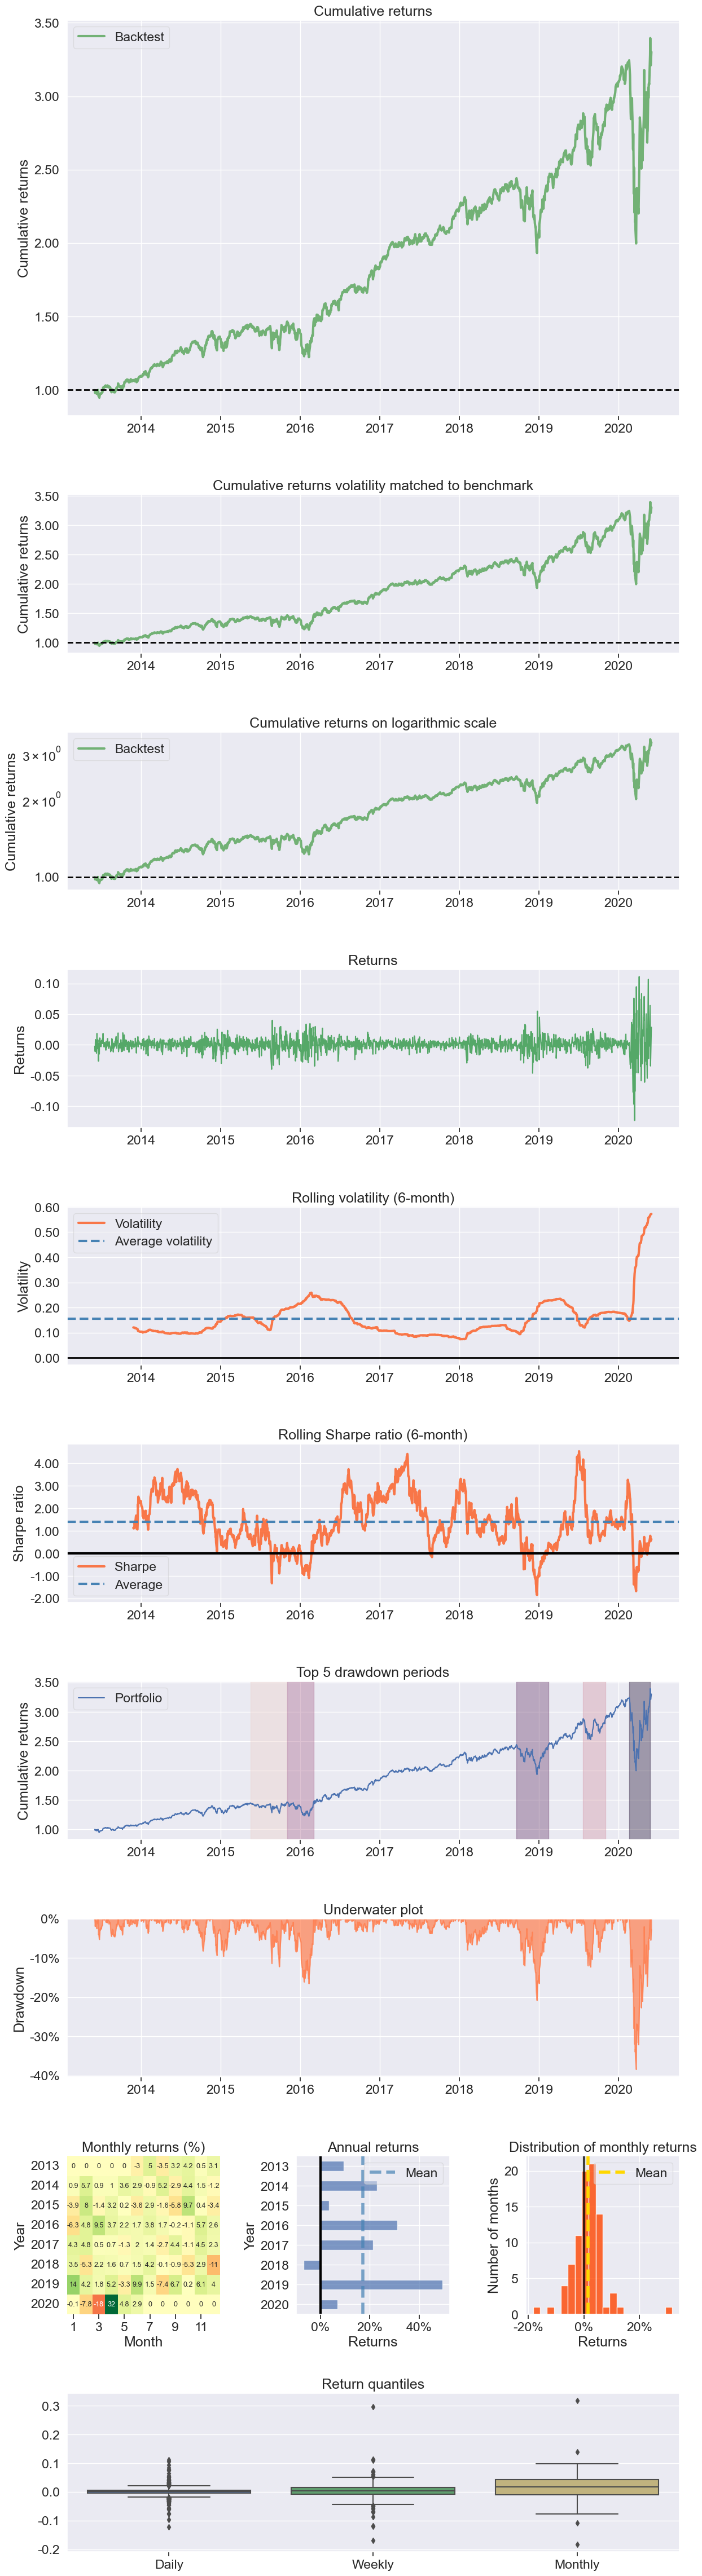

In [32]:
pf.create_returns_tear_sheet(daily_return)

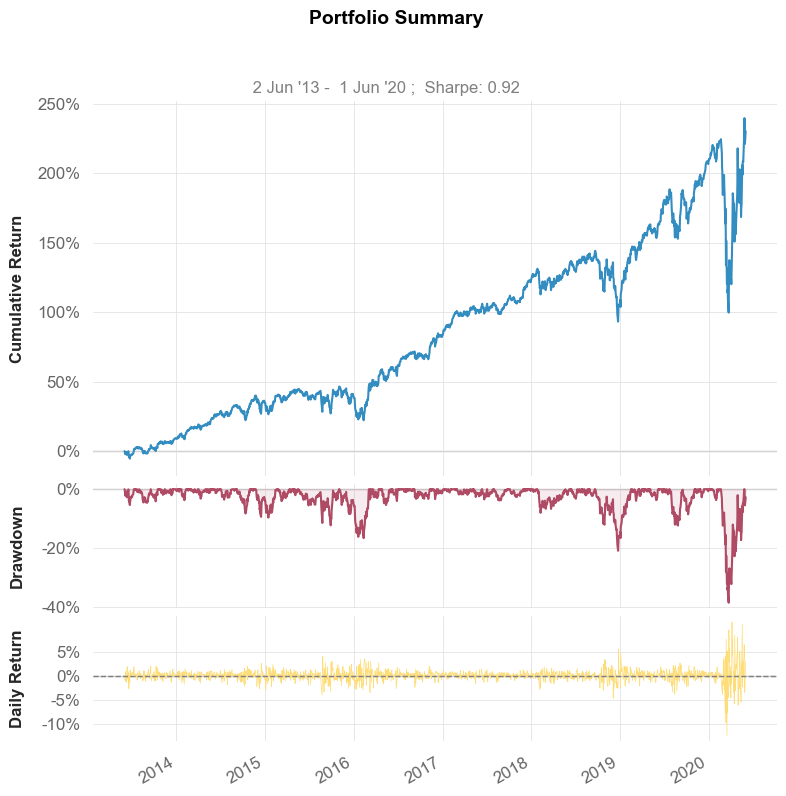

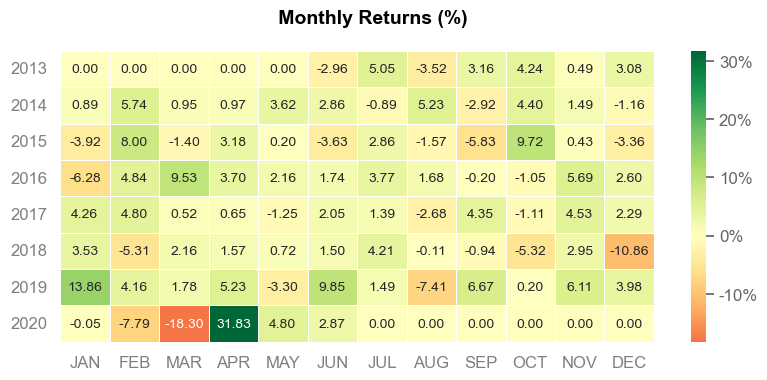

In [33]:
qs.reports.plots(daily_return, mode='basic')

In [34]:
qs.reports.metrics(daily_return, benchmark=benchmark_return, mode='basic')

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2013-06-03  2013-06-03
End Period          2020-06-01  2020-06-01
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   230.21%     87.38%
CAGR﹪              18.61%      9.39%

Sharpe              0.92        0.61
Prob. Sharpe Ratio  99.23%      94.32%
Sortino             1.35        0.84
Sortino/√2          0.96        0.6
Omega               1.21        1.21

Max Drawdown        -38.45%     -33.92%
Longest DD Days     166         416

Gain/Pain Ratio     0.21        0.14
Gain/Pain (1M)      1.35        0.86

Payoff Ratio        0.98        0.93
Profit Factor       1.21        1.14
Common Sense Ratio  1.22        1.01
CPC Index           0.65        0.57
Tail Ratio          1.01        0.89
Outlier Win Ratio   3.99        5.11
Outlier Loss Ratio  4.04        4.89

MTD                 2.87%       0.38%
3M                  16.11%      3.44%

### 3-3 다른 기간에 대한 검증

##### 2020-06-01~2023-01-30까지의 기간에 대해 해당전략을 적용하고, 성과를 평가해보기로함

##### **해당 기간의 누적수익률은 58.02%로 좋은 수익률을 보임(연간 18.72%)**    
##### **해당기간의 벤치마크(SP500) 누적수익률은 31.98%(연간 10.97%)**      
##### **변동성이 높기는 하지만  더 높은 샤프비율 등으로 미뤄볼 때 이 전략은 유효하다고 할 수 있다.**

In [35]:
start, end = "2020-06-01", "2023-01-30"

factor_df = sp500.pct_change(80).dropna().mul(-1)
factor_df = factor_df[(factor_df.index >= start) & (factor_df.index <= end)]

price_df = sp500[(sp500.index >= start) & (sp500.index <= end)]

In [36]:
benchmark_return = benchmark.pct_change().dropna()
benchmark_return = benchmark_return[(benchmark_return.index >= start) & (benchmark_return.index <= end)]

In [37]:
rebalance_period=40
rebalance_dates = factor_df.index[::rebalance_period].tolist()
signal = backtest.generate_signal_using_factor(factor_df, n_positions=100,
                                               long_min=-np.inf, short_max=np.inf, long_short=False)
weights = backtest.generate_equal_weight_portfolio_from_signal(signal, n_positions=100,
                                                              n_min_positions=0, long_short=False)
daily_return= backtest.backtest_from_weights(price_df, weights, money,
                                            rebalance_dates, commission, tax, interest)

In [38]:
factor_test = backtest.test_factor(5, price_df, factor_df, money, rebalance_dates, 
                                   commission, interest, tax)
factor_test

,Q1,Q2,Q3,Q4,Q5
Annualized_return,0.269878,0.186662,0.143544,0.153617,0.198881
Annualized_std,0.199336,0.182689,0.186639,0.202335,0.256243
Annualized_sharpe,1.298851,1.028501,0.812255,0.807604,0.836027
MDD,-0.179853,-0.206742,-0.213894,-0.225051,-0.237632


In [39]:
summary_stats = backtest.summary_stats(daily_return,rf=0, alpha=0.05, min_return=0, year=252, benchmark=benchmark_return)
summary_stats

,Portfolio,Benchmark
Cumulative Return,58.02%,31.98%
Annualized Return,18.72%,10.97%
Annualized Std,25.58%,19.25%
Annualized Sharpe,79.86%,63.70%
MDD,-23.45%,-25.43%
Var,-23.36%,-20.70%
C_Var,-34.05%,-28.74%
Shortfall Prob(min_return=0.00%),23.22%,28.45%


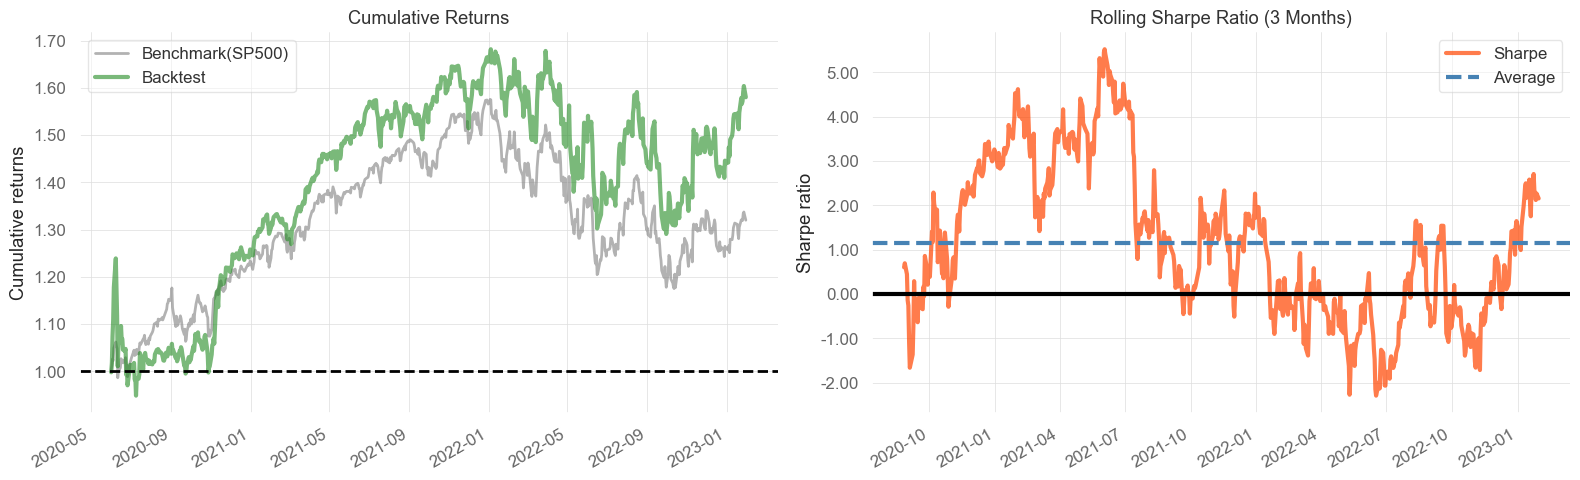

In [40]:
benchmark_return.name='Benchmark(SP500)'
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(daily_return,
                     factor_returns=benchmark_return,
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout()

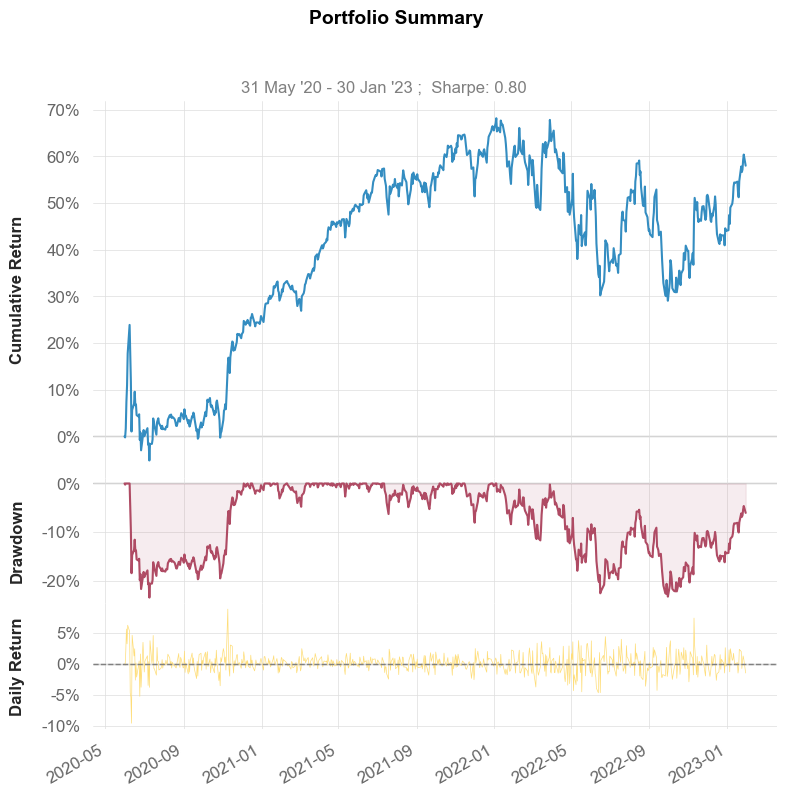

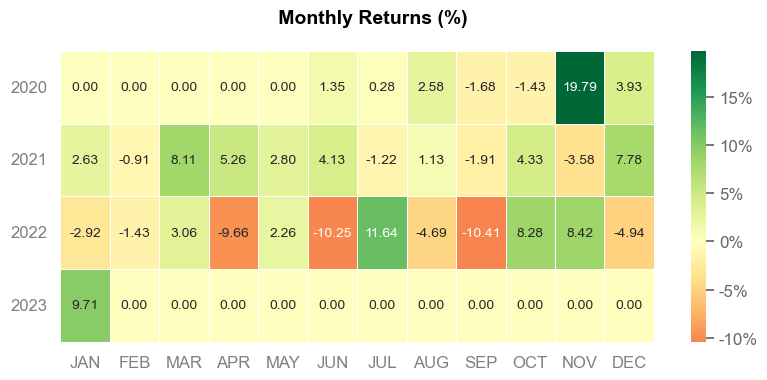

In [41]:
qs.reports.plots(daily_return, mode='basic')

In [42]:
qs.reports.metrics(daily_return, benchmark=benchmark_return, mode='basic')

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2020-06-01  2020-06-01
End Period          2023-01-30  2023-01-30
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   58.02%      31.98%
CAGR﹪              18.72%      10.97%

Sharpe              0.8         0.64
Prob. Sharpe Ratio  90.38%      84.88%
Sortino             1.18        0.89
Sortino/√2          0.84        0.63
Omega               1.15        1.15

Max Drawdown        -23.45%     -25.43%
Longest DD Days     390         391

Gain/Pain Ratio     0.15        0.11
Gain/Pain (1M)      1.0         0.56

Payoff Ratio        1.05        1.01
Profit Factor       1.15        1.11
Common Sense Ratio  1.39        1.05
CPC Index           0.63        0.59
Tail Ratio          1.21        0.94
Outlier Win Ratio   2.97        3.86
Outlier Loss Ratio  3.56        4.4

MTD                 9.71%       4.64%
3M                  12.17%      2.99